In [27]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data 

In [28]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
df_hom = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'
                     'mouse_human_homologs.txt', sep='\t')
GS_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/gwas_max_abs_z.top500.gs'

In [29]:
dic_data_raw = {}
dic_data_processed = {}

# Aizarani et al. Liver atlas
dic_data_raw['halpern'] = dl.load_halpern_shenhav_raw_data(opt='raw')
dic_data_processed['halpern'] = dl.load_halpern_shenhav_raw_data(opt='processed')

DNAME_LIST = ['halpern']

### Load score 

In [30]:
SCORE_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.mouse_liver_halpern.gwas_max_abs_z.top500'
SCORE_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/score_file/score.mouse_liver_halpern_full.gwas_max_abs_z.top500'
df_score = None
trait_list = []
for file in [x for x in os.listdir(SCORE_PATH) if '.score.gz' in x]:
    trait = file.replace('.score.gz','')
    trait_list.append(trait)
    temp_df = pd.read_csv(join(SCORE_PATH,file), sep='\t', index_col=0)
    temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
    temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]

    if df_score is None:
        df_score = temp_df.copy()
    else:
        df_score = pd.concat([df_score, temp_df], axis=1)

In [33]:
cell_list = sorted(list(set(df_score.index) & set(dic_data_raw['halpern'].obs_names)))
dic_data_raw['halpern'] = dic_data_raw['halpern'][cell_list, :].copy()
dic_data_processed['halpern'] = dic_data_processed['halpern'][cell_list, :].copy()

IndexError: arrays used as indices must be of integer (or boolean) type

### Analysis 

In [38]:
# Interesting traits 
trait_plot_list = []
for trait in trait_list:
    v_fdr = df_score['%s.fdr'%trait].values
    if (v_fdr<0.2).sum()>5:
        print(trait, (v_fdr<0.2).sum())
        trait_plot_list.append(trait)

UKB_460K.blood_LYMPHOCYTE_COUNT 18
UKB_460K.blood_EOSINOPHIL_COUNT 26
UKB_460K.blood_MEAN_PLATELET_VOL 47
UKB_460K.blood_MONOCYTE_COUNT 26
UKB_460K.biochemistry_AspartateAminotransferase 49
UKB_460K.disease_AID_ALL 16


In [16]:
trait_plot_list = ['UKB_460K.biochemistry_TotalBilirubin',
 'UKB_460K.biochemistry_DirectBilirubin',
 'UKB_460K.biochemistry_AlanineAminotransferase',
 'UKB_460K.biochemistry_Testosterone_Male',
 'UKB_460K.disease_HI_CHOL_SELF_REP',
 'PASS_Multiple_sclerosis',
 'UKB_460K.disease_THYROID_ANY_SELF_REP',
 'UKB_460K.biochemistry_ApolipoproteinA',
 'UKB_460K.biochemistry_ApolipoproteinB',
 'UKB_460K.biochemistry_LDLdirect',
 'UKB_460K.biochemistry_Cholesterol',
 'UKB_460K.biochemistry_SHBG',
 'PASS_HDL',
 'UKB_460K.biochemistry_AlkalinePhosphatase',
 'UKB_460K.biochemistry_VitaminD',
 'PASS_LDL',
 'UKB_460K.biochemistry_Triglycerides',
 'UKB_460K.biochemistry_HDLcholesterol',
 'PASS_Triglycerides']

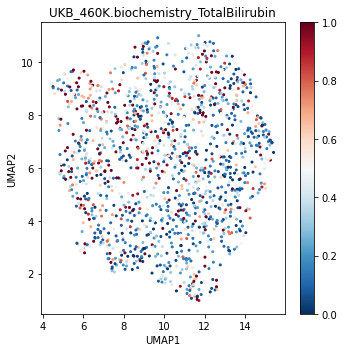

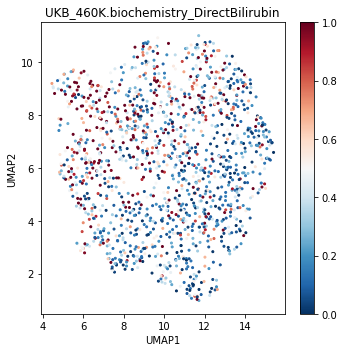

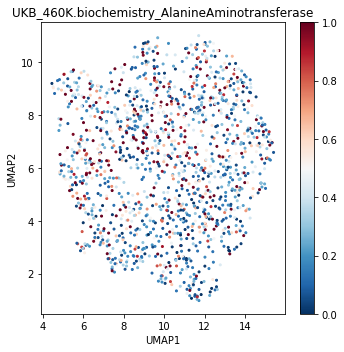

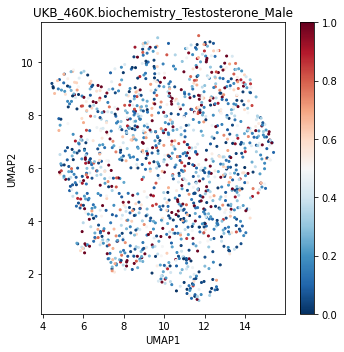

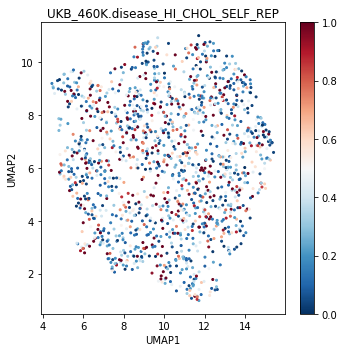

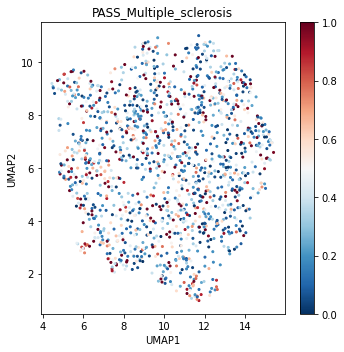

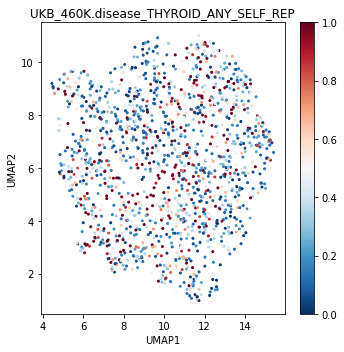

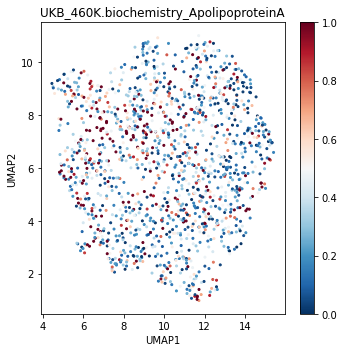

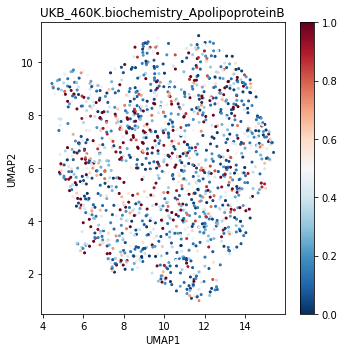

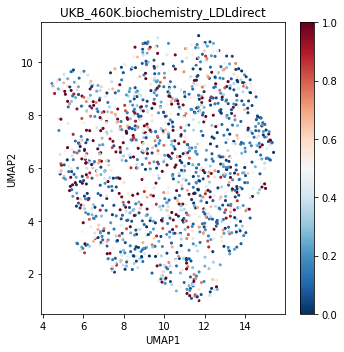

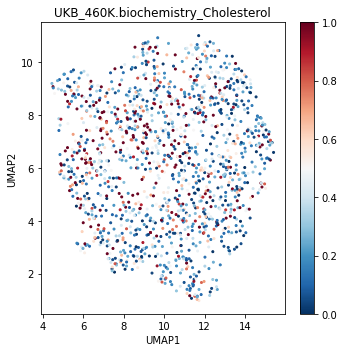

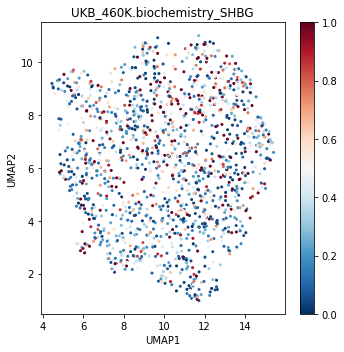

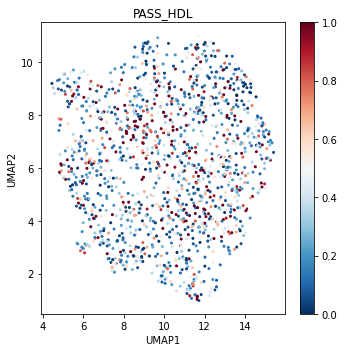

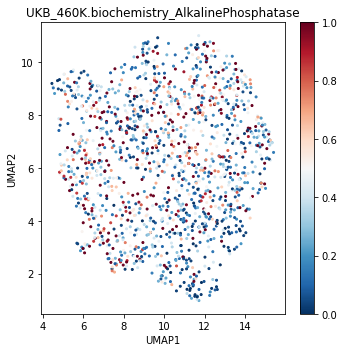

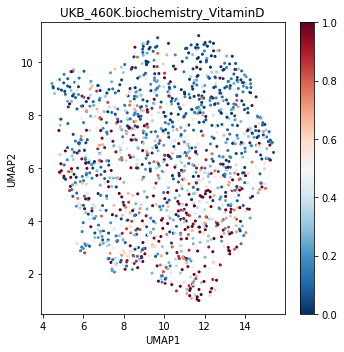

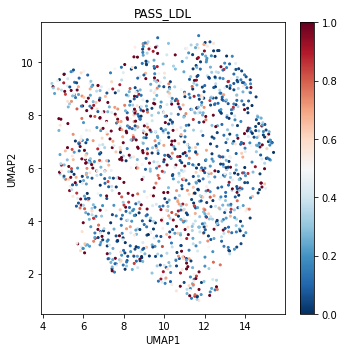

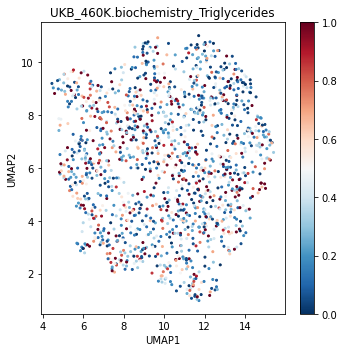

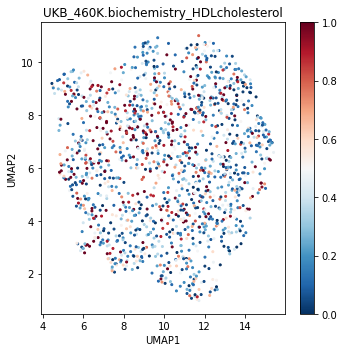

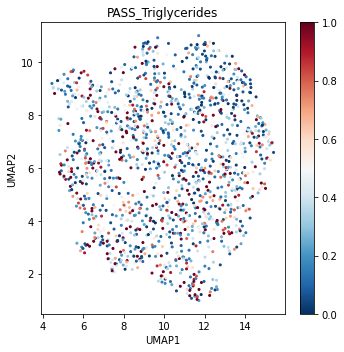

In [26]:
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,
                           data={'UMAP1':dic_data_processed['halpern'].obsm['X_umap'][:,0],
                                 'UMAP2':dic_data_processed['halpern'].obsm['X_umap'][:,1],
                                 'zsc':-np.log10(df_score.loc[cell_list, '%s.mc_pval'%trait].values)})
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=1, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()

In [23]:
gene_list = ['Cyp2f2', 'Cyp2e1']
for gene in gene_list: 
    if gene not in dic_data_raw['halpern'].var_names:
        print(gene)

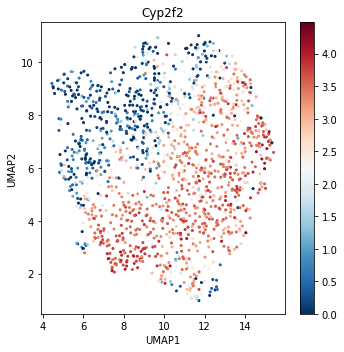

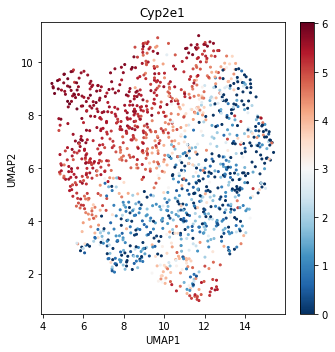

In [24]:
adata_small = dic_data_raw['halpern'].copy()
cell_list = list(adata_small.obs.index)

df_plot = pd.DataFrame(index=cell_list,
                       data={x:adata_small[:,x].X.toarray().reshape([-1]) for x in gene_list})
df_umap = pd.DataFrame(index=dic_data_processed['halpern'].obs_names,
                       data={'UMAP1':dic_data_processed['halpern'].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_processed['halpern'].obsm['X_umap'][:,1]})
df_plot = df_plot.join(df_umap)

for gene in gene_list:
    
    plt.figure(figsize=[5,5])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[gene],
                cmap='RdBu_r', s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%gene)
    plt.tight_layout()
    plt.show()

In [24]:
df_zonation = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/liver_atlas/'
                          'Aizarani_Nature_2019_liver_supp_table3.txt', sep='\t', index_col=0)

In [25]:
df_zonation

,Module,P301_8_130,P301_8_127,P301_5_28,P301_4_98,P301_17_5,P301_10_123,P301_4_103,P301_8_131,P301_8_154,...,P301_6_175,P301_6_147,P301_18_146,P301_6_141,P301_6_153,P301_6_123,P301_6_181,P301_12_161,P301_6_178,P301_18_176
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
ACADM,1,-1.892985,-1.889814,-1.886645,-1.883479,-1.880315,-1.877153,-1.873993,-1.870836,-1.867681,...,-0.084579,-0.094507,-0.104455,-0.114421,-0.124406,-0.134410,-0.144433,-0.154474,-0.164533,-0.174611
AFM,1,-2.374369,-2.373595,-2.372819,-2.372039,-2.371257,-2.370472,-2.369684,-2.368893,-2.368099,...,0.565645,0.562683,0.559714,0.556738,0.553756,0.550767,0.547772,0.544771,0.541763,0.538749
AGL,1,-1.811760,-1.811965,-1.812166,-1.812363,-1.812555,-1.812744,-1.812929,-1.813109,-1.813285,...,2.140241,2.145407,2.150576,2.155749,2.160924,2.166102,2.171283,2.176467,2.181653,2.186842
ANTXR2,1,-1.799543,-1.797541,-1.795538,-1.793535,-1.791532,-1.789528,-1.787524,-1.785520,-1.783516,...,0.547106,0.546021,0.544938,0.543857,0.542777,0.541699,0.540624,0.539550,0.538479,0.537409
APLP2,1,-3.630012,-3.621315,-3.612630,-3.603959,-3.595299,-3.586652,-3.578018,-3.569395,-3.560785,...,0.962515,0.966911,0.971313,0.975720,0.980132,0.984550,0.988973,0.993401,0.997835,1.002273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPS19,35,1.950090,1.949356,1.948621,1.947886,1.947152,1.946417,1.945681,1.944946,1.944209,...,-2.185280,-2.188392,-2.191506,-2.194622,-2.197741,-2.200862,-2.203984,-2.207109,-2.210237,-2.213366
RPS9,35,1.899189,1.896911,1.894635,1.892362,1.890091,1.887822,1.885555,1.883291,1.881028,...,-2.033410,-2.034628,-2.035842,-2.037053,-2.038260,-2.039464,-2.040665,-2.041862,-2.043056,-2.044246
SEC14L2,35,2.087039,2.084403,2.081768,2.079134,2.076500,2.073868,2.071236,2.068605,2.065975,...,-1.725249,-1.725800,-1.726347,-1.726892,-1.727434,-1.727972,-1.728507,-1.729040,-1.729569,-1.730095


In [29]:
(adata.obs['celltype']=='hepatocytes').sum()

3040

In [26]:
# Diffusion map 
adata = dic_data_raw['aizarani'].copy()
# adata = dic_data_raw['aizarani'][dic_data_processed['aizarani'].obsm['X_umap'][:,0]<0,:].copy()
# adata = adata[adata.obs['celltype']=='hepatocytes'].copy()
sc.pp.filter_genes(adata, min_cells=20)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=100)
# sc.tl.umap(adata)
# adata = adata[dic_data_processed['aizarani'].obsm['X_umap'][:,0]<0,:].copy()
# adata = adata[adata.obs['celltype']=='hepatocytes'].copy()
sc.tl.diffmap(adata)

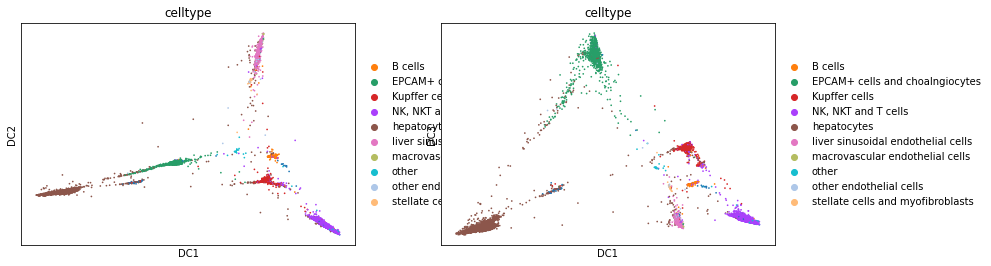

In [28]:
sc.pl.diffmap(adata, color='celltype', components=['1,2', '1,3'])

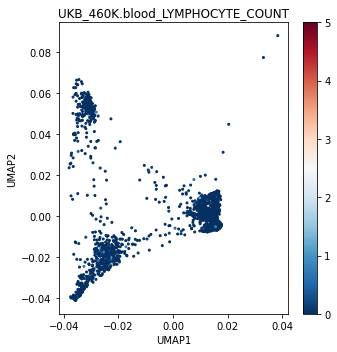

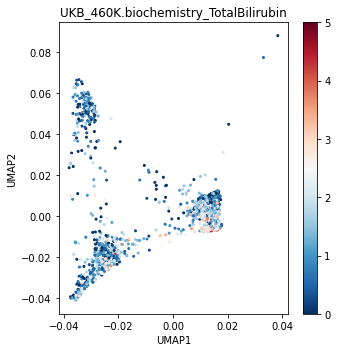

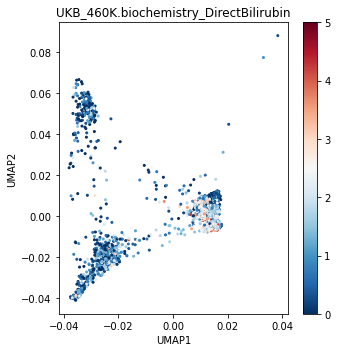

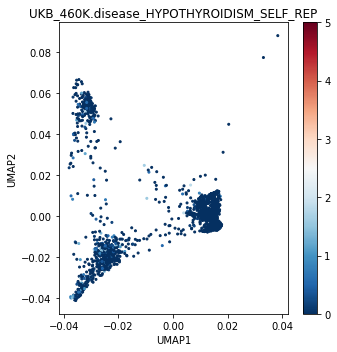

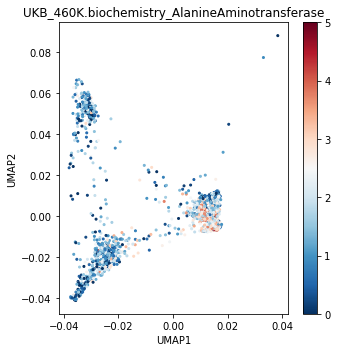

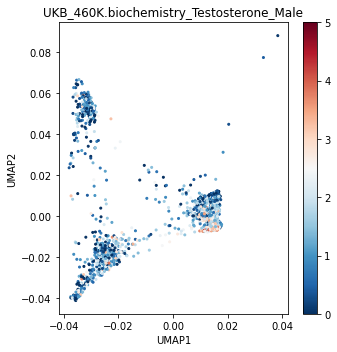

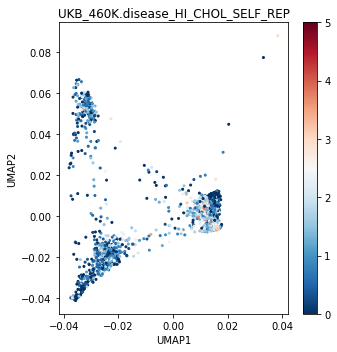

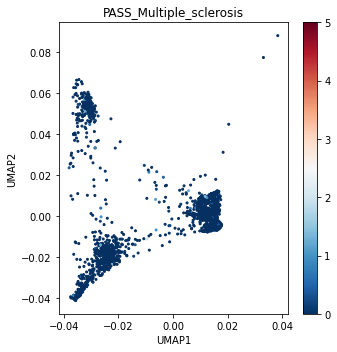

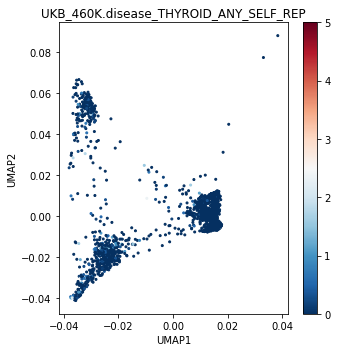

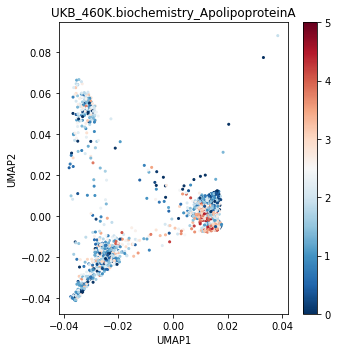

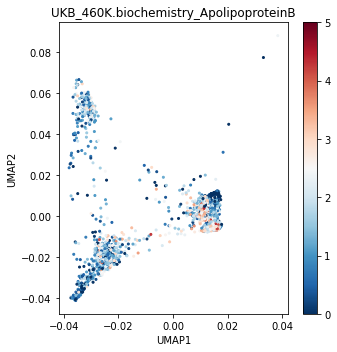

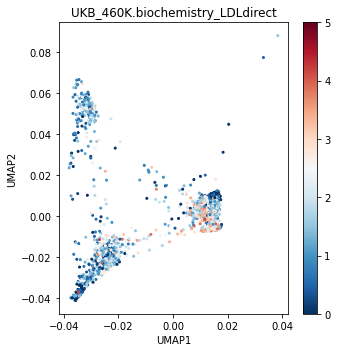

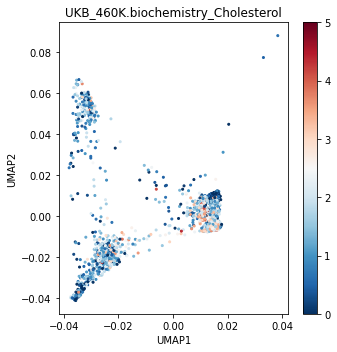

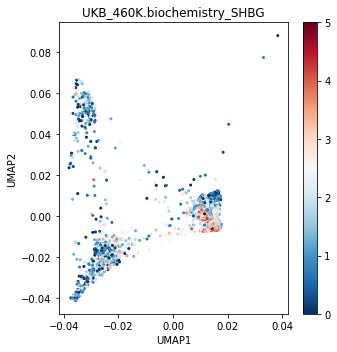

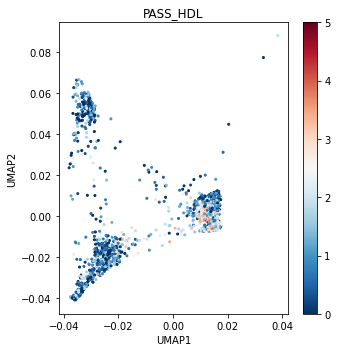

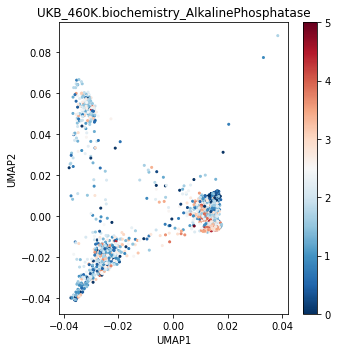

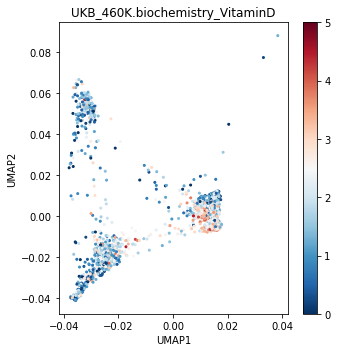

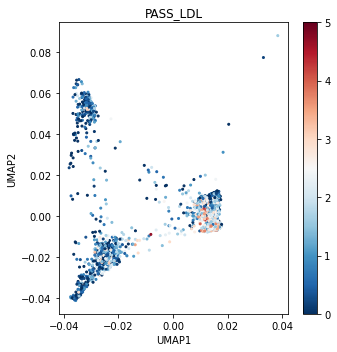

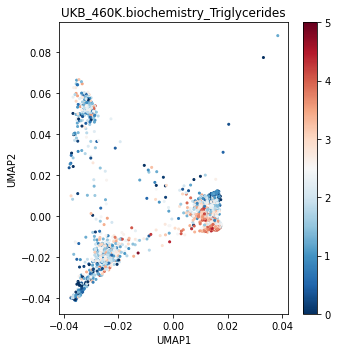

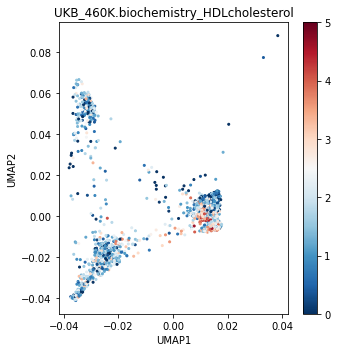

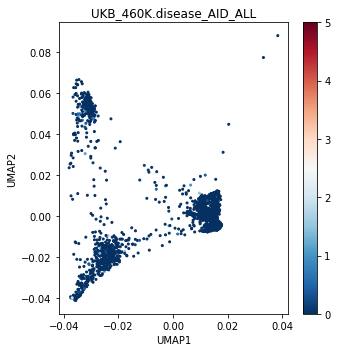

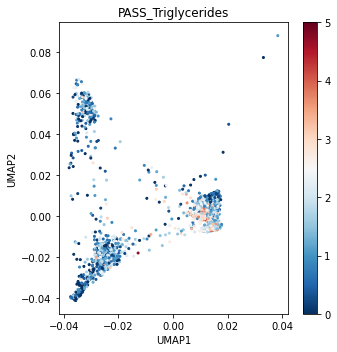

In [22]:
cell_list = list(adata.obs.index)
for trait in trait_plot_list:
    df_plot = pd.DataFrame(index=cell_list,
                           data={'DC1':adata.obsm['X_diffmap'][:,1],
                                 'DC2':adata.obsm['X_diffmap'][:,3],
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    
    plt.figure(figsize=[5,5])
    max_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.99)
    min_ = np.quantile(np.absolute(df_plot['zsc'].values), 0.01)
    plt.scatter(df_plot['DC1'], df_plot['DC2'], c=df_plot['zsc'],
                cmap='RdBu_r', vmax=5, vmin=0, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s'%trait)
    plt.tight_layout()
    plt.show()

In [32]:
for trait in trait_plot_list:
    temp_list = list(set(cell_list) & )
    df_plot = pd.DataFrame(index=cell_list,
                           data={'SOM':df_zonation.loc[cell_list,'Module'].values,
                                 'zsc':df_score.loc[cell_list, '%s.zscore'%trait].values})
    
    plt.figure(figsize=[5,5])
    plt.scatter(df_plot['SOM'], df_plot['zsc'], s=4)
    plt.xlabel('SOM')
    plt.ylabel('zsc')
    plt.title('%s'%trait)
    plt.tight_layout()

KeyError: "None of [Index(['ASGR1_CD45_UNB_P4_7_173', 'ASGR1_CD45_UNB_P4_8_144',\n       'ASGR1_CD45_UNB_P4_8_173', 'ASGR1pos304_5_6', 'ASGR1pos304_5_7',\n       'ASGR1pos304_5_8', 'ASGR1pos304_5_11', 'ASGR1pos304_5_18',\n       'ASGR1pos304_5_20', 'ASGR1pos304_5_28',\n       ...\n       'PHH_UNB_3_19', 'PHH_UNB_3_83', 'PHH_UNB_3_173', 'PHH_UNB_4_113',\n       'PHH_UNB_4_122', 'PHH_UNB_4_126', 'PHH_UNB_4_168', 'PHH_UNB_4_173',\n       'PHH_UNB_4_179', 'Trop2pos315_3_89'],\n      dtype='object', length=3040)] are in the [index]"